In [84]:
#Install nltk
!conda install nltk 

# Imports the library
import nltk 

#Download the necessary datasets
nltk.download()

Solving environment: ...working... done

# All requested packages already installed.

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [120]:
# Step 1: Load Data

In [127]:
messages = [line.rstrip() for line in open('SMSSpamCollection')]
print len(messages)

5574


In [128]:
for message_no, message in enumerate(messages[:10]):
    print message_no, message
    print '\n'

0 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...


1 ham	Ok lar... Joking wif u oni...


2 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's


3 ham	U dun say so early hor... U c already then say...


4 ham	Nah I don't think he goes to usf, he lives around here though


5 spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv


6 ham	Even my brother is not like to speak with me. They treat me like aids patent.


7 ham	As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune


8 spam	WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code 

In [129]:
#This is a TSV file. 
#First column is a label saying whether the given message is a normal message (commonly known as "ham") or "spam". 
#The second column is the message itself. 

#In this notebook, we will train a machine learning model to learn to discriminate between ham/spam automatically. 
#Then, with a trained model, we will be able to classify arbitrary unlabeled messages as ham or spam.

In [130]:
import pandas

In [131]:
messages = pandas.read_csv('SMSSpamCollection', sep='\t',names=["label", "message"])
messages.head(10)

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [132]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
label      5572 non-null object
message    5572 non-null object
dtypes: object(2)
memory usage: 87.1+ KB


In [133]:
# Step 2: Basic Data Exploratory Analysis

In [134]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [135]:
messages.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

In [136]:
messages['length'] = messages['message'].apply(len)
messages.head(10)

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61
5,spam,FreeMsg Hey there darling it's been 3 week's n...,148
6,ham,Even my brother is not like to speak with me. ...,77
7,ham,As per your request 'Melle Melle (Oru Minnamin...,160
8,spam,WINNER!! As a valued network customer you have...,158
9,spam,Had your mobile 11 months or more? U R entitle...,154


In [137]:
#Import libraries for visualization

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

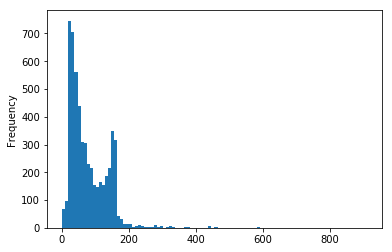

In [138]:
messages['length'].plot(bins=100, kind='hist') 

In [139]:
messages.length.describe()

count    5572.000000
mean       80.616296
std        60.015593
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

In [140]:
#Max length of message is 910 characters

In [141]:
messages[messages['length'] == 910]['message'].iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000000014B5C940>,
      dtype=object)

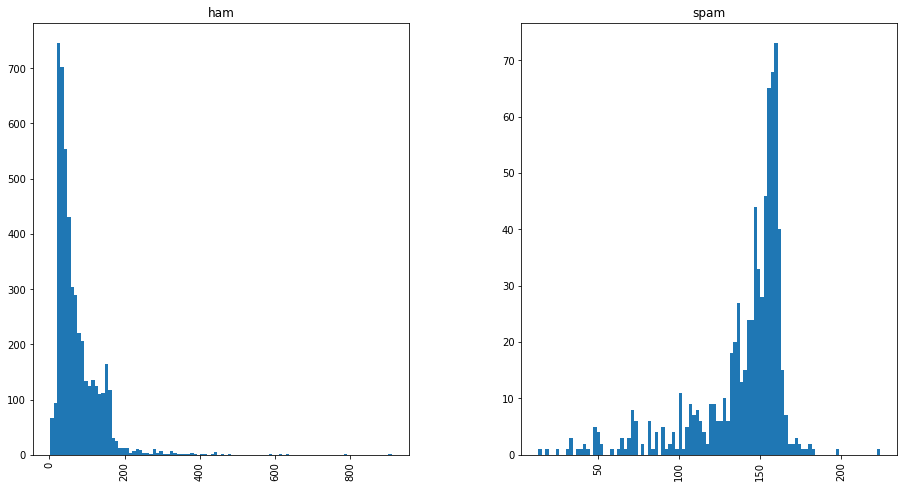

In [142]:
messages.hist(column='length', by='label', bins=100,figsize=(15,8))

In [143]:
#Through just basic EDA we've been able to discover a trend that spam messages tend to have more characters.

In [144]:
# Step 3: Text Pre-Processing

In [145]:
#Our main issue with our data is that it is all in text format (strings). 
#The classification algorithms that we've learned about so far will need some sort of numerical feature vector 
#in order to perform the classification task. 
#There are actually many methods to convert a corpus to a vector format. 
#The simplest is the the bag-of-words approach, where each unique word in a text will be represented by one number.

In [146]:
#As a first step, let's write a function that will split a message into its individual words and return a list. 
#We will also remove very common words, ('the', 'a', etc..). 
#To do this we will take advantage of the NLTK library.

In [147]:
import string

mess = 'Sample message! Notice: it has punctuation.'

# Check characters to see if they are in punctuation
nopunc = [char for char in mess if char not in string.punctuation]

# Join the characters again to form the string.
nopunc = ''.join(nopunc)

#Check word after removing punctuation
nopunc

'Sample message Notice it has punctuation'

In [148]:
from nltk.corpus import stopwords
stopwords.words('english')[0:20] # Show some stop words

[u'i',
 u'me',
 u'my',
 u'myself',
 u'we',
 u'our',
 u'ours',
 u'ourselves',
 u'you',
 u"you're",
 u"you've",
 u"you'll",
 u"you'd",
 u'your',
 u'yours',
 u'yourself',
 u'yourselves',
 u'he',
 u'him',
 u'his']

In [149]:
nopunc.split()

['Sample', 'message', 'Notice', 'it', 'has', 'punctuation']

In [150]:
# Now just remove any stopwords
clean_mess = [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [151]:
clean_mess

['Sample', 'message', 'Notice', 'punctuation']

In [152]:
#Apply the above function on our DataFrame

def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [153]:
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [154]:
#Now let's "tokenize" these messages. Tokenization is just the term used to describe 
#the process of converting the normal text strings in to a list of tokens (words that we actually want).

In [155]:
# Check to make sure its working
messages['message'].head(5).apply(text_process)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: message, dtype: object

In [156]:
#There are a lot of ways to continue normalizing this text. Such as Stemming or distinguishing by part of speech.

#NLTK has lots of built-in tools and great documentation on a lot of these methods. 
#Sometimes they don't work well for text-messages due to the way a lot of people tend to use abbreviations or shorthand

In [157]:
# Step 4: Vectorization

In [158]:
#Now we'll convert each message, represented as a list of tokens (lemmas) above, 
#into a vector that machine learning models can understand.

#We can do that in three steps using the bag-of-words model:

# 1) Count how many times does a word occur in each message (Known as term frequency)

# 2) Weigh the counts, so that frequent tokens get lower weight (inverse document frequency)

# 3) Normalize the vectors to unit length, to abstract from the original text length (L2 norm)

#Let's begin the first step:

#Each vector will have as many dimensions as there are unique words in the SMS corpus. 
#We will first use SciKit Learn's CountVectorizer. 
#This model will convert a collection of text documents to a matrix of token counts.

#We can imagine this as a 2-Dimensional matrix. Where the 1-dimension is the entire vocabulary (1 row per word) 
#and the other dimension are the actual documents, in this case a column per text message.


In [159]:
from sklearn.feature_extraction.text import CountVectorizer

In [160]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(messages['message'])

# Print total number of vocab words
print len(bow_transformer.vocabulary_)

C:\Users\jthak\Anaconda2\lib\site-packages\ipykernel_launcher.py:17: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


11425


In [161]:
message4 = messages['message'][3]
print(message4)

U dun say so early hor... U c already then say...


In [162]:
bow4 = bow_transformer.transform([message4])
print bow4
print bow4.shape

  (0, 4068)	2
  (0, 4629)	1
  (0, 5261)	1
  (0, 6204)	1
  (0, 6222)	1
  (0, 7186)	1
  (0, 9554)	2
(1, 11425)


In [163]:
#This means that there are seven unique words in message number 4 (after removing common stop words). 
#Two of them appear twice, the rest only once. 

In [165]:
print bow_transformer.get_feature_names()[4068]
print bow_transformer.get_feature_names()[9554]

U
say


In [166]:
# We can use .transform on our Bag-of-Words (bow) transformed object and transform the entire DataFrame of messages

In [167]:
messages_bow = bow_transformer.transform(messages['message'])
print 'Shape of Sparse Matrix: ', messages_bow.shape
print 'Amount of Non-Zero occurences: ', messages_bow.nnz
print 'sparsity: %.2f%%' % (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1]))

C:\Users\jthak\Anaconda2\lib\site-packages\ipykernel_launcher.py:17: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


Shape of Sparse Matrix:  (5572, 11425)
Amount of Non-Zero occurences:  50548
sparsity: 0.08%


In [168]:
#After the counting, the term weighting and normalization can be done with TF-IDF, using scikit-learn's TfidfTransformer.

In [169]:
#TF-IDF stands for term frequency-inverse document frequency, 
#and the tf-idf weight is a weight often used in information retrieval and text mining. 
#This weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus. 
#The importance increases proportionally to the number of times a word appears in the document 
#but is offset by the frequency of the word in the corpus. 
#Variations of the tf-idf weighting scheme are often used by search engines as a central tool in scoring 
#and ranking a document's relevance given a user query.

In [170]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf4 = tfidf_transformer.transform(bow4)
print tfidf4

  (0, 9554)	0.5385626262927564
  (0, 7186)	0.4389365653379857
  (0, 6222)	0.3187216892949149
  (0, 6204)	0.29953799723697416
  (0, 5261)	0.29729957405868723
  (0, 4629)	0.26619801906087187
  (0, 4068)	0.40832589933384067


In [171]:
print tfidf_transformer.idf_[bow_transformer.vocabulary_['u']]
print tfidf_transformer.idf_[bow_transformer.vocabulary_['university']]

3.2800524267409408
8.527076498901426


In [172]:
messages_tfidf = tfidf_transformer.transform(messages_bow)
print messages_tfidf.shape

(5572, 11425)


In [173]:
# Step 5: Training a model

In [174]:
from sklearn.naive_bayes import MultinomialNB
spam_detect_model = MultinomialNB().fit(messages_tfidf, messages['label'])

In [175]:
print 'predicted:', spam_detect_model.predict(tfidf4)[0]
print 'expected:', messages.label[3]

predicted: ham
expected: ham


In [176]:
# Step 6: Model Evaluation

In [177]:
all_predictions = spam_detect_model.predict(messages_tfidf)
print all_predictions

['ham' 'ham' 'spam' ... 'ham' 'ham' 'ham']


In [178]:
from sklearn.metrics import classification_report
print classification_report(messages['label'], all_predictions)

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      4825
        spam       1.00      0.85      0.92       747

   micro avg       0.98      0.98      0.98      5572
   macro avg       0.99      0.92      0.95      5572
weighted avg       0.98      0.98      0.98      5572



In [179]:
from sklearn.model_selection import train_test_split

msg_train, msg_test, label_train, label_test = \
train_test_split(messages['message'], messages['label'], test_size=0.2)

print len(msg_train), len(msg_test), len(msg_train) + len(msg_test)

4457 1115 5572


In [180]:
#The test size is 20% of the entire dataset (1115 messages out of total 5572), 
#and the training is the rest (4457 out of 5572). 
#Note the default split would have been 30/70.

In [181]:
# Step 7: Creating a data pipeline

In [182]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [183]:
pipeline.fit(msg_train,label_train)
predictions = pipeline.predict(msg_test)
print classification_report(predictions,label_test)

C:\Users\jthak\Anaconda2\lib\site-packages\ipykernel_launcher.py:17: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


              precision    recall  f1-score   support

         ham       1.00      0.96      0.98      1002
        spam       0.73      1.00      0.85       113

   micro avg       0.96      0.96      0.96      1115
   macro avg       0.87      0.98      0.91      1115
weighted avg       0.97      0.96      0.97      1115

